# 2D Tile Placement Testing & Visualization

This notebook tests various solvers for the 2D tile placement problem and provides visualization and validation of the solutions.

## Methods Compared:
- Neural Solver (deep reinforcement learning)
- Greedy Solver 
- ACO (Ant Colony Optimization) Solver
- Exact Solver (for small instances)

Each solution is validated and visualized as a grid showing tile placements.

In [38]:
#!/usr/bin/env python3
"""
Test the neural model with make_dataset and compare with baseline methods.
Includes visualization and validation of solutions.
"""

import time
import random
import numpy as np
import torch
import csv
from datetime import datetime
from typing import List, Dict, Any, Optional, Tuple
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import seaborn as sns

# Import modules from the project
from train import make_dataset, evaluate_instance
from net import NeuralSolver, TileCNN
from env import precompute_tile_embeddings, make_synthetic_tiles, TilePlacementEnv, layout_bbox
from greedy import greedy_place_once, GreedyParams
from aco import solve_with_aco, ACOParams
from exact import exact_bruteforce_min_canvas

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Imports successful!")

Imports successful!


## Configuration Parameters

In [ ]:
# Configuration parameters
CONFIG = {
    # Dataset parameters
    "T": 50,                    # Number of tiles
    "n": 3,                     # Tile size (nxn)
    "alphabet": 2,              # Alphabet size
    "test_size": 1,             # Number of test instances
    "seed": 42,                 # Random seed
    
    # Neural model parameters
    "checkpoint": "./checkpoints/reinforce_T30_n4_a2_bs16_train256_val16/ep50.pt",  # Path to checkpoint
    "d_tile": 64,               # Tile embedding dimension
    "d_model": 128,             # Model hidden dimension
    "cand_feat_dim": 10,        # Candidate feature dimension
    "temperature": 0.7,         # Sampling temperature
    "greedy_inference": True,   # Use greedy inference
    
    # Which methods to test
    "test_neural": True,        # Test neural solver
    "test_greedy": True,        # Test greedy solver
    "test_aco": True,           # Test ACO solver
    "test_exact": False,         # Test exact solver (small instances only)
    
    # ACO parameters
    "aco_iterations": 50,       # ACO iterations
    "aco_ants": 8,              # Number of ACO ants
    
    # Device
    "device": "auto",           # Device (cuda/cpu/auto)
}

# Set device
if CONFIG["device"] == "auto":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device(CONFIG["device"])

print(f"Configuration loaded. Using device: {device}")
print(f"Testing {CONFIG['test_size']} instances with T={CONFIG['T']}, n={CONFIG['n']}, alphabet={CONFIG['alphabet']}")

Configuration loaded. Using device: cuda
Testing 1 instances with T=10, n=3, alphabet=2


## Utility Functions

In [40]:
def load_neural_model(checkpoint_path: str, alphabet: int, device: torch.device,
                      d_tile: int = 64, d_model: int = 128, cand_feat_dim: int = 10) -> tuple:
    """Load neural model and tile CNN from checkpoint."""
    if not Path(checkpoint_path).exists():
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")
    
    print(f"Loading neural model from {checkpoint_path}")
    ckpt = torch.load(checkpoint_path, map_location=device)
    
    # Create models
    model = NeuralSolver(
        c_occ=alphabet + 1,
        d_tile=d_tile,
        d_model=d_model,
        cand_feat_dim=cand_feat_dim,
    ).to(device)
    
    tile_cnn = TileCNN(in_ch=alphabet, d_tile=d_tile).to(device)
    
    # Load model state
    if "model" in ckpt:
        model.load_state_dict(ckpt["model"])
    elif "state_dict" in ckpt:
        model.load_state_dict(ckpt["state_dict"])
    else:
        # Try loading directly
        model.load_state_dict(ckpt)
    
    # Load tile CNN state
    if "tile_cnn" in ckpt:
        tile_cnn.load_state_dict(ckpt["tile_cnn"])
    elif "tilecnn" in ckpt:
        tile_cnn.load_state_dict(ckpt["tilecnn"])
    else:
        print("[Warning] TileCNN weights not found in checkpoint, using random initialization")
    
    model.eval()
    tile_cnn.eval()
    
    return model, tile_cnn


def construct_solution_grid(tiles: List[np.ndarray], placements: Dict[int, Tuple[int, int]], 
                           alphabet: int) -> Tuple[np.ndarray, Dict]:
    """Construct the solution grid from tile placements."""
    if not placements:
        return np.array([]), {}
    
    n = tiles[0].shape[0]
    
    # Calculate bounding box
    m, bbox = layout_bbox(placements, n)
    xmin, xmax, ymin, ymax = bbox
    
    # Create grid
    grid_h = xmax - xmin + 1
    grid_w = ymax - ymin + 1
    grid = np.full((grid_h, grid_w), -1, dtype=int)  # -1 = empty
    tile_id_grid = np.full((grid_h, grid_w), -1, dtype=int)  # Track which tile is at each position
    
    # Place tiles
    for tile_id, (x, y) in placements.items():
        tile = tiles[tile_id]
        rel_x = x - xmin
        rel_y = y - ymin
        
        for i in range(n):
            for j in range(n):
                grid_x = rel_x + i
                grid_y = rel_y + j
                if 0 <= grid_x < grid_h and 0 <= grid_y < grid_w:
                    grid[grid_x, grid_y] = tile[i, j]
                    tile_id_grid[grid_x, grid_y] = tile_id
    
    info = {
        "bbox": bbox,
        "m": m,
        "tile_id_grid": tile_id_grid,
        "n": n
    }
    
    return grid, info


def validate_solution(tiles: List[np.ndarray], placements: Dict[int, Tuple[int, int]], 
                     alphabet: int) -> Dict[str, Any]:
    """Validate a solution by checking for conflicts."""
    if not placements:
        return {
            "valid": False, 
            "error": "No placements provided", 
            "conflicts": [],
            "num_conflicts": 0,
            "canvas_size": 0,  # 0 for empty solutions
            "num_placed_tiles": 0
        }
    
    n = tiles[0].shape[0]
    conflicts = []
    occupancy = {}
    
    # Check each tile placement
    for tile_id, (x, y) in placements.items():
        tile = tiles[tile_id]
        
        # Check for conflicts with existing occupancy
        for i in range(n):
            for j in range(n):
                pos = (x + i, y + j)
                tile_val = int(tile[i, j])
                
                if pos in occupancy:
                    existing_val = occupancy[pos]
                    if existing_val != tile_val:
                        conflicts.append({
                            "position": pos,
                            "tile_id": tile_id,
                            "expected": existing_val,
                            "found": tile_val
                        })
                else:
                    occupancy[pos] = tile_val
    
    # Calculate canvas size
    m, _ = layout_bbox(placements, n)
    
    return {
        "valid": len(conflicts) == 0,
        "conflicts": conflicts,
        "num_conflicts": len(conflicts),
        "canvas_size": m,
        "num_placed_tiles": len(placements)
    }


def visualize_solution(tiles: List[np.ndarray], placements: Dict[int, Tuple[int, int]], 
                      alphabet: int, title: str = "Solution", figsize: Tuple[int, int] = (10, 10)):
    """Visualize a tile placement solution."""
    if not placements:
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.text(0.5, 0.5, "No solution found", ha='center', va='center', 
                fontsize=16, transform=ax.transAxes)
        ax.set_title(title)
        ax.axis('off')
        return fig, ax
    
    # Construct solution grid
    grid, info = construct_solution_grid(tiles, placements, alphabet)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Solution values
    if grid.size > 0:
        # Create colormap: -1 (empty) = white, 0,1,2,... = different colors
        colors = ['white'] + list(plt.cm.Set3.colors[:alphabet])
        cmap = ListedColormap(colors)
        
        im1 = ax1.imshow(grid, cmap=cmap, vmin=-1, vmax=alphabet-1)
        ax1.set_title(f"{title} - Values (M={info['m']})")
        
        # Add grid lines
        ax1.set_xticks(np.arange(-0.5, grid.shape[1], 1), minor=True)
        ax1.set_yticks(np.arange(-0.5, grid.shape[0], 1), minor=True)
        ax1.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
        ax1.tick_params(which="minor", size=0)
        
        # Add text annotations
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                if grid[i, j] >= 0:
                    ax1.text(j, i, str(grid[i, j]), ha='center', va='center', 
                            color='black', fontweight='bold')
    
    # Plot 2: Tile boundaries
    if grid.size > 0:
        tile_id_grid = info['tile_id_grid']
        n = info['n']
        
        # Create colormap for tile IDs
        num_tiles = len(placements)
        tile_colors = plt.cm.tab20(np.linspace(0, 1, num_tiles))
        tile_cmap = ListedColormap(['white'] + list(tile_colors))
        
        im2 = ax2.imshow(tile_id_grid, cmap=tile_cmap, vmin=-1, vmax=num_tiles-1)
        ax2.set_title(f"{title} - Tiles")
        
        # Add tile boundaries
        for tile_id, (x, y) in placements.items():
            rel_x = x - info['bbox'][0]
            rel_y = y - info['bbox'][2]
            
            # Draw rectangle around tile
            rect = patches.Rectangle((rel_y - 0.5, rel_x - 0.5), n, n,
                                   linewidth=2, edgecolor='black', facecolor='none')
            ax2.add_patch(rect)
            
            # Add tile ID label
            ax2.text(rel_y + n/2 - 0.5, rel_x + n/2 - 0.5, str(tile_id),
                    ha='center', va='center', color='white', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
        
        ax2.set_xticks(np.arange(-0.5, grid.shape[1], 1), minor=True)
        ax2.set_yticks(np.arange(-0.5, grid.shape[0], 1), minor=True)
        ax2.grid(which="minor", color="gray", linestyle='-', linewidth=0.5, alpha=0.5)
        ax2.tick_params(which="minor", size=0)
    
    plt.tight_layout()
    return fig, (ax1, ax2)


def visualize_tiles(tiles: List[np.ndarray], title: str = "Input Tiles", max_cols: int = 8):
    """Visualize the input tiles."""
    n_tiles = len(tiles)
    n_cols = min(max_cols, n_tiles)
    n_rows = (n_tiles + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(n_tiles):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        
        tile = tiles[i]
        im = ax.imshow(tile, cmap='Set3', vmin=0, vmax=tile.max())
        ax.set_title(f"Tile {i}")
        ax.axis('off')
        
        # Add text annotations
        for r in range(tile.shape[0]):
            for c in range(tile.shape[1]):
                ax.text(c, r, str(tile[r, c]), ha='center', va='center',
                       color='black', fontweight='bold')
    
    # Hide unused subplots
    for i in range(n_tiles, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    return fig, axes

print("Utility functions defined!")

Utility functions defined!


## Solver Functions

In [41]:
def test_neural_solver(model: NeuralSolver, tile_cnn: TileCNN, tiles: List[np.ndarray], 
                      alphabet: int, device: torch.device, 
                      temperature: float = 0.7, greedy: bool = True,
                      max_steps: int = 2000, verbose: bool = False) -> Dict[str, Any]:
    """Test neural solver on a set of tiles."""
    env = TilePlacementEnv(tiles, alphabet=alphabet)
    
    # Precompute tile embeddings
    tile_embs = precompute_tile_embeddings(
        env.tiles, env.alphabet, tile_cnn, device, keep_on_device=(device.type == "cuda")
    )
    
    start_time = time.time()
    m, steps = evaluate_instance(model, env, tile_embs, device, temperature=temperature, greedy=greedy)
    solve_time = time.time() - start_time
    
    if verbose:
        print(f"Neural Solver: m={m}, time={solve_time:.3f}s, steps={steps}")
    
    return {
        "method": "Neural",
        "best_m": int(m),
        "time": solve_time,
        "status": "ok" if env.done else "incomplete",
        "placements": dict(env.placements),
        "steps": steps
    }


def test_greedy_solver(tiles: List[np.ndarray], seed: int = 42, K: int = 16, 
                      perimeter_limit: int = 64, verbose: bool = False) -> Dict[str, Any]:
    """Test greedy solver on a set of tiles."""
    params = GreedyParams(K=K, rng_seed=seed, perimeter_search_limit=perimeter_limit)
    
    start_time = time.time()
    result = greedy_place_once(tiles, params)
    solve_time = time.time() - start_time
    
    if verbose:
        print(f"Greedy Solver: m={result['best_m']}, time={solve_time:.3f}s")
    
    return {
        "method": "Greedy",
        "best_m": result["best_m"],
        "time": solve_time,
        "status": result["status"],
        "placements": result["placements"]
    }


def test_aco_solver(tiles: List[np.ndarray], seed: int = 42, iterations: int = 50, 
                   n_ants: int = 8, n_workers: int = 4, verbose: bool = False,
                   enable_wandb: bool = False) -> Dict[str, Any]:
    """Test ACO solver on a set of tiles."""
    params = ACOParams(
        alpha=1.0, beta=3.0, gamma=1.0, lam=0.05, epsilon=1.0, rho=0.10,
        Q=float(tiles[0].shape[0] ** 2), n_ants=n_ants, iterations=iterations,
        random_seed=seed, perimeter_search_limit=32, enable_compaction=False,
        n_workers=n_workers, enable_wandb=enable_wandb
    )
    
    start_time = time.time()
    result = solve_with_aco(tiles, params)
    solve_time = time.time() - start_time
    
    if verbose:
        print(f"ACO Solver: m={result['best_m']}, time={solve_time:.3f}s")
    
    return {
        "method": "ACO",
        "best_m": result["best_m"],
        "time": solve_time,
        "status": result["status"],
        "placements": result["placements"]
    }


def test_exact_solver(tiles: List[np.ndarray], time_limit: float = None, 
                     verbose: bool = False) -> Dict[str, Any]:
    """Test exact solver on a set of tiles."""
    start_time = time.time()
    result = exact_bruteforce_min_canvas(tiles, time_limit=None, verbose=verbose)
    solve_time = time.time() - start_time
    
    if verbose:
        print(f"Exact Solver: m={result['best_m']}, time={solve_time:.3f}s")
    
    return {
        "method": "Exact",
        "best_m": result["best_m"],
        "time": solve_time,
        "status": result["status"],
        "placements": result.get("best_placements", {})
    }

print("Solver functions defined!")

Solver functions defined!


## Initialize Models and Random Seeds

In [42]:
# Set random seeds
torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
random.seed(CONFIG["seed"])

# Load neural model if checkpoint is provided
neural_model, tile_cnn = None, None
if CONFIG["test_neural"] and CONFIG["checkpoint"]:
    try:
        neural_model, tile_cnn = load_neural_model(
            CONFIG["checkpoint"], CONFIG["alphabet"], device,
            CONFIG["d_tile"], CONFIG["d_model"], CONFIG["cand_feat_dim"]
        )
        print(f"Successfully loaded neural model from {CONFIG['checkpoint']}")
    except Exception as e:
        print(f"Failed to load neural model: {e}")
        CONFIG["test_neural"] = False

print("\nModels initialized!")
print(f"Will test: Neural={CONFIG['test_neural']}, Greedy={CONFIG['test_greedy']}, ACO={CONFIG['test_aco']}, Exact={CONFIG['test_exact']}")

Loading neural model from ./checkpoints/reinforce_T30_n4_a2_bs16_train256_val16/ep50.pt
[Warning] TileCNN weights not found in checkpoint, using random initialization
Successfully loaded neural model from ./checkpoints/reinforce_T30_n4_a2_bs16_train256_val16/ep50.pt

Models initialized!
Will test: Neural=True, Greedy=True, ACO=True, Exact=False
[Warning] TileCNN weights not found in checkpoint, using random initialization
Successfully loaded neural model from ./checkpoints/reinforce_T30_n4_a2_bs16_train256_val16/ep50.pt

Models initialized!
Will test: Neural=True, Greedy=True, ACO=True, Exact=False


## Generate and Visualize Test Instances

Generated 1 test instances

First instance has 10 tiles of size 3x3


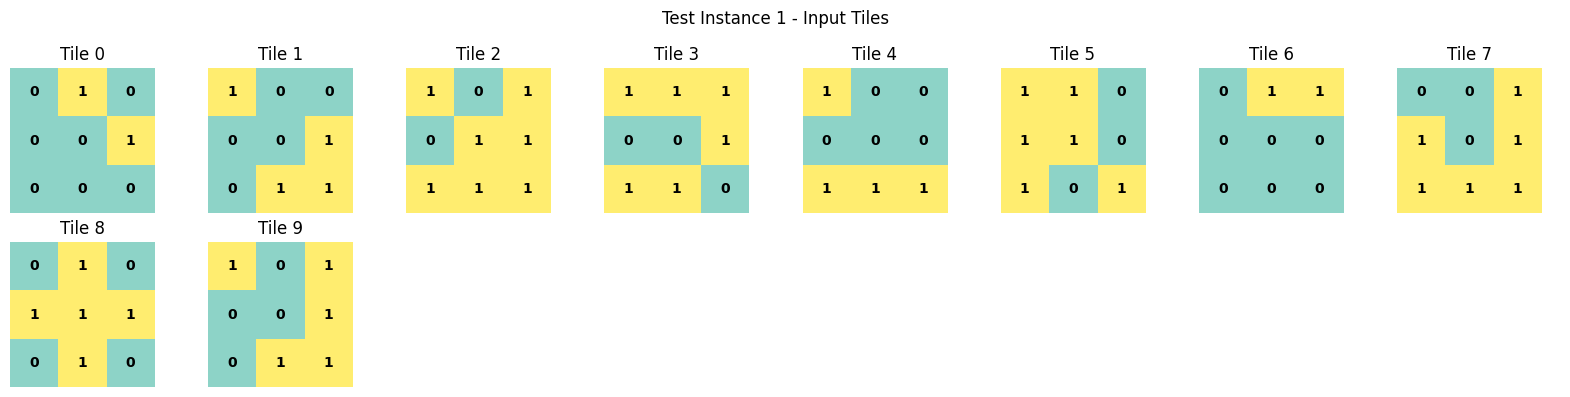

In [43]:
# Generate test instances
test_instances = []
for i in range(CONFIG["test_size"]):
    tiles = make_synthetic_tiles(T=CONFIG["T"], n=CONFIG["n"], 
                                alphabet=CONFIG["alphabet"], seed=CONFIG["seed"] + i)
    test_instances.append(tiles)

print(f"Generated {len(test_instances)} test instances")

# Visualize first instance's tiles
print(f"\nFirst instance has {len(test_instances[0])} tiles of size {CONFIG['n']}x{CONFIG['n']}")
fig, axes = visualize_tiles(test_instances[0], "Test Instance 1 - Input Tiles")
plt.show()

## Run Tests and Visualize Solutions

In [44]:
all_results = []

for instance_id, tiles in enumerate(test_instances):
    print(f"\n{'='*80}")
    print(f"TEST INSTANCE {instance_id + 1}/{CONFIG['test_size']}")
    print(f"{'='*80}")
    
    instance_results = {}
    instance_seed = CONFIG["seed"] + instance_id
    
    # Test Neural Solver
    if CONFIG["test_neural"] and neural_model is not None:
        print("\nTesting Neural Solver...")
        try:
            result = test_neural_solver(neural_model, tile_cnn, tiles, CONFIG["alphabet"], 
                                      device, temperature=CONFIG["temperature"], 
                                      greedy=CONFIG["greedy_inference"], verbose=True)
            instance_results["neural"] = result
        except Exception as e:
            print(f"Neural solver failed: {e}")
            instance_results["neural"] = {"method": "Neural", "error": str(e)}
    
    # Test Greedy Solver
    if CONFIG["test_greedy"]:
        print("\nTesting Greedy Solver...")
        try:
            result = test_greedy_solver(tiles, seed=instance_seed, verbose=True)
            instance_results["greedy"] = result
        except Exception as e:
            print(f"Greedy solver failed: {e}")
            instance_results["greedy"] = {"method": "Greedy", "error": str(e)}
    
    # Test ACO Solver
    if CONFIG["test_aco"]:
        print("\nTesting ACO Solver...")
        try:
            result = test_aco_solver(tiles, seed=instance_seed, 
                                   iterations=CONFIG["aco_iterations"], 
                                   n_ants=CONFIG["aco_ants"], verbose=True)
            instance_results["aco"] = result
        except Exception as e:
            print(f"ACO solver failed: {e}")
            instance_results["aco"] = {"method": "ACO", "error": str(e)}
    
    # Test Exact Solver 
    if CONFIG["test_exact"]:
        print("\nTesting Exact Solver...")
        try:
            result = test_exact_solver(tiles, verbose=True)
            instance_results["exact"] = result
        except Exception as e:
            print(f"Exact solver failed: {e}")
            instance_results["exact"] = {"method": "Exact", "error": str(e)}
    elif CONFIG["test_exact"]:
        print("\nSkipping exact solver (too many tiles)")
    
    all_results.append(instance_results)
    
    # Print comparison table
    print("\n" + "="*60)
    print("INSTANCE RESULTS")
    print("="*60)
    print(f"{'Method':<12} {'Best M':<8} {'Time (s)':<10} {'Status':<12}")
    print("-"*60)
    
    valid_methods = []
    for method_name, result in instance_results.items():
        if "error" in result:
            print(f"{result['method']:<12} {'ERROR':<8} {'-':<10} {result['error']:<12}")
        else:
            print(f"{result['method']:<12} {result['best_m']:<8} "
                  f"{result['time']:<10.3f} {result.get('status', 'N/A'):<12}")
            valid_methods.append((method_name, result))
    
    if valid_methods:
        best_method_name, best_result = min(valid_methods, key=lambda x: x[1]["best_m"])
        print("-"*60)
        print(f"Best: {best_result['method']} with M = {best_result['best_m']}")
    
    print(f"\nInstance {instance_id + 1} completed!")


TEST INSTANCE 1/1

Testing Neural Solver...
Neural Solver: m=9, time=0.127s, steps=9

Testing Greedy Solver...
Greedy Solver: m=10, time=0.020s

Testing ACO Solver...


ACO Iterations:   0%|          | 0/50 [00:00<?, ?iter/s]

ACO Iterations: 100%|██████████| 50/50 [00:01<00:00, 47.82iter/s]

ACO Solver: m=8, time=1.110s

INSTANCE RESULTS
Method       Best M   Time (s)   Status      
------------------------------------------------------------
Neural       9        0.127      ok          
Greedy       10       0.020      ok          
ACO          8        1.110      ok          
------------------------------------------------------------
Best: ACO with M = 8

Instance 1 completed!


## Validate and Visualize Solutions for Each Instance


VALIDATION & VISUALIZATION - INSTANCE 1

Input tiles for instance 1:


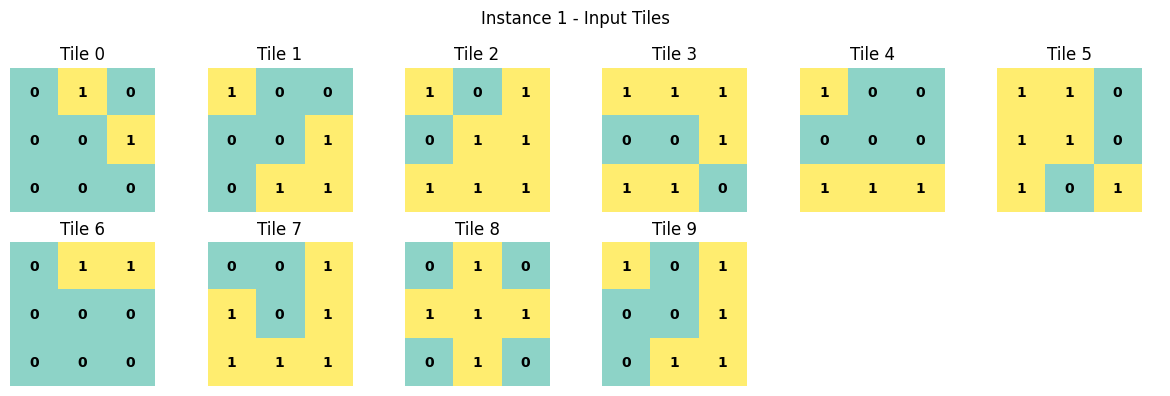


--------------------------------------------------
Neural Solver Solution
--------------------------------------------------
Validation: ✓ VALID
Canvas size (M): 9
Placed tiles: 10/10


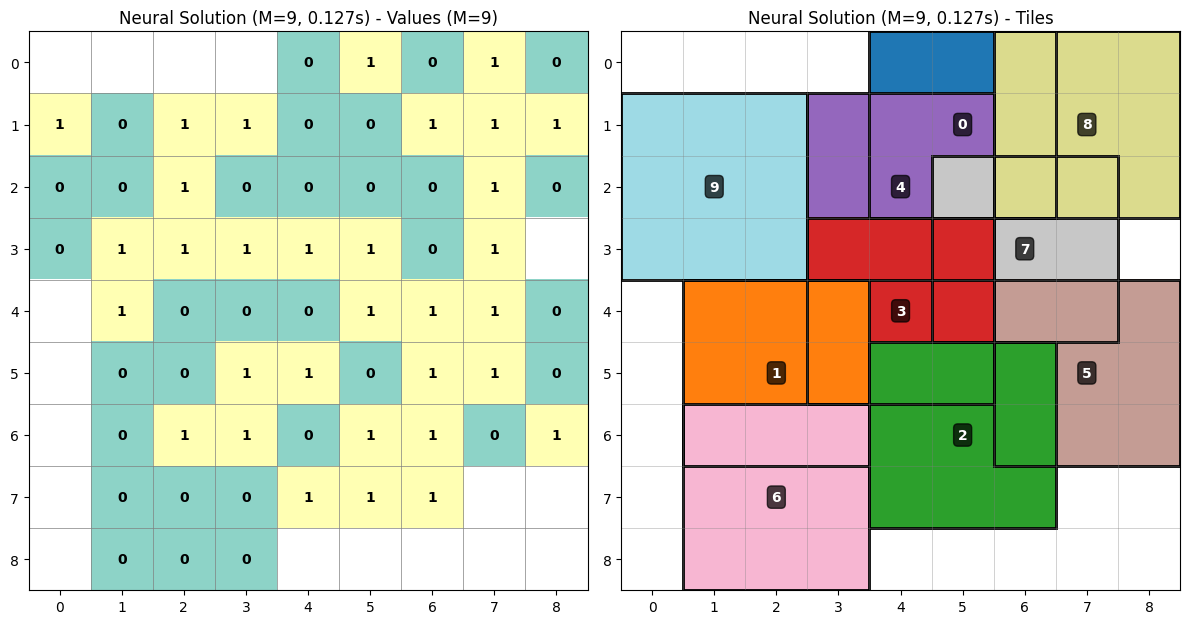

Solution time: 0.127s
Status: ok

--------------------------------------------------
Greedy Solver Solution
--------------------------------------------------
Validation: ✓ VALID
Canvas size (M): 10
Placed tiles: 10/10


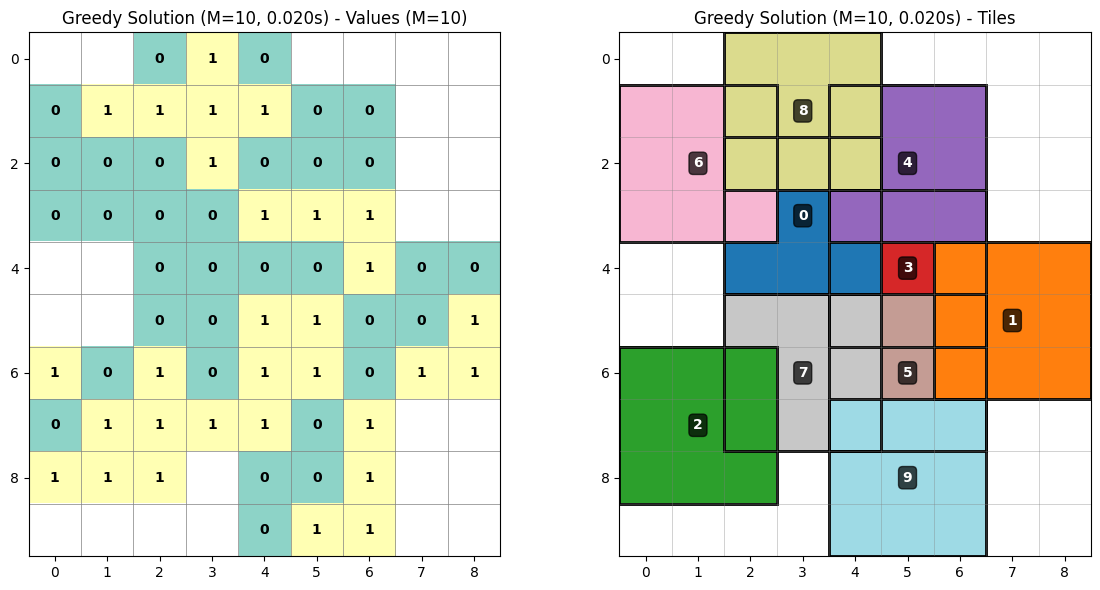

Solution time: 0.020s
Status: ok

--------------------------------------------------
ACO Solver Solution
--------------------------------------------------
Validation: ✓ VALID
Canvas size (M): 8
Placed tiles: 10/10


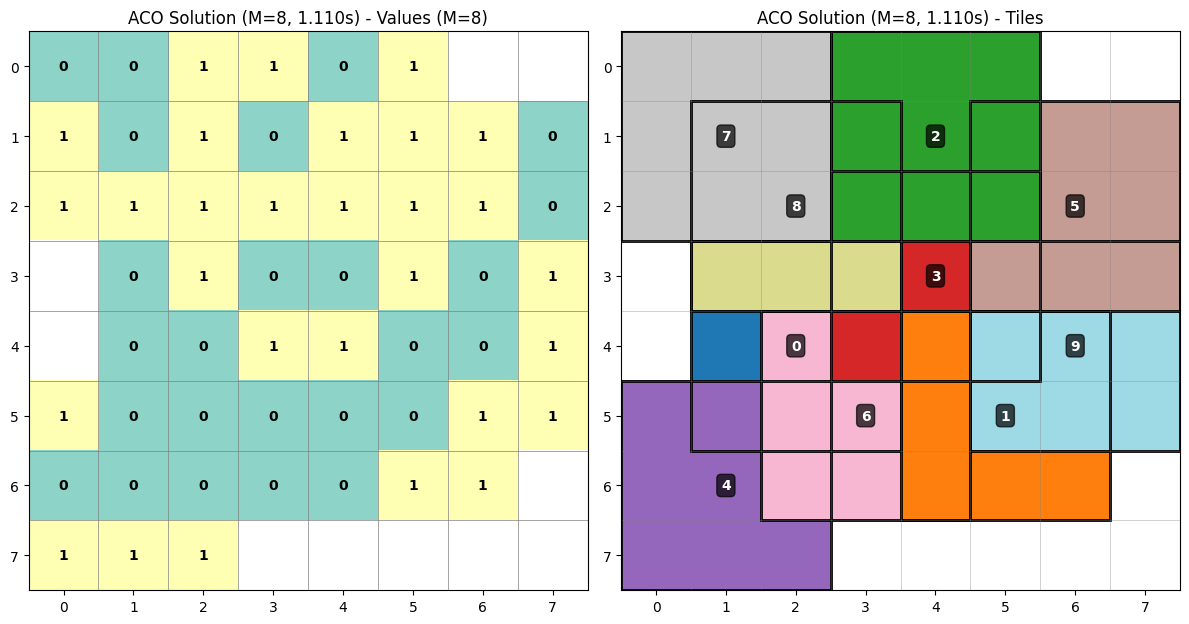

Solution time: 1.110s
Status: ok


In [45]:
for instance_id, (tiles, instance_results) in enumerate(zip(test_instances, all_results)):
    print(f"\n{'='*80}")
    print(f"VALIDATION & VISUALIZATION - INSTANCE {instance_id + 1}")
    print(f"{'='*80}")
    
    # Show input tiles
    print(f"\nInput tiles for instance {instance_id + 1}:")
    fig, axes = visualize_tiles(tiles, f"Instance {instance_id + 1} - Input Tiles", max_cols=6)
    plt.show()
    
    for method_name, result in instance_results.items():
        if "error" in result:
            print(f"\n{result['method']} Solver: FAILED - {result['error']}")
            continue
        
        print(f"\n{'-'*50}")
        print(f"{result['method']} Solver Solution")
        print(f"{'-'*50}")
        
        # Check if this is a failed solution (empty placements but claiming success)
        is_empty_solution = len(result['placements']) == 0
        
        if is_empty_solution:
            status = result.get('status', 'unknown')
            if status == 'ok':
                print(f"⚠️  Solver reported 'ok' but found no solution (likely timed out)")
            else:
                print(f"❌ Solver failed to find a solution (status: {status})")
        
        # Validate solution
        validation = validate_solution(tiles, result["placements"], CONFIG["alphabet"])
        
        print(f"Validation: {'✓ VALID' if validation['valid'] else '✗ INVALID'}")
        print(f"Canvas size (M): {validation['canvas_size']}")
        print(f"Placed tiles: {validation['num_placed_tiles']}/{len(tiles)}")
        
        if not validation['valid']:
            if validation.get('error'):
                print(f"❌ Error: {validation['error']}")
            else:
                num_conflicts = validation.get('num_conflicts', 0)
                print(f"⚠️  Conflicts: {num_conflicts}")
                conflicts = validation.get('conflicts', [])
                for conflict in conflicts[:3]:  # Show first 3 conflicts
                    print(f"  - Position {conflict['position']}: expected {conflict['expected']}, found {conflict['found']} (tile {conflict['tile_id']})")
                if len(conflicts) > 3:
                    print(f"  - ... and {len(conflicts) - 3} more conflicts")
        
        # Visualize solution (even if empty, for completeness)
        title = f"{result['method']} Solution (M={result['best_m']}, {result['time']:.3f}s)"
        if is_empty_solution:
            title += " - NO SOLUTION FOUND"
        
        fig, axes = visualize_solution(tiles, result["placements"], CONFIG["alphabet"], 
                                     title=title, figsize=(12, 6))
        plt.show()
        
        print(f"Solution time: {result['time']:.3f}s")
        print(f"Status: {result.get('status', 'N/A')}")
        
        # Additional analysis for empty solutions
        if is_empty_solution:
            print(f"🔍 Analysis: The {result['method']} solver spent {result['time']:.1f}s but didn't place any tiles.")
            if result['time'] > 25:  # Assume timeout if > 25s
                print(f"   This likely indicates the problem was too difficult and the solver timed out.")

## Aggregate Results and Analysis


AGGREGATE RESULTS ANALYSIS

ACO Solver:
  Successful runs: 1/1
  Best M - Mean: 8.00 ± 0.00
         Range: [8, 8]
  Time   - Mean: 1.110s ± 0.000s

Greedy Solver:
  Successful runs: 1/1
  Best M - Mean: 10.00 ± 0.00
         Range: [10, 10]
  Time   - Mean: 0.020s ± 0.000s

Neural Solver:
  Successful runs: 1/1
  Best M - Mean: 9.00 ± 0.00
         Range: [9, 9]
  Time   - Mean: 0.127s ± 0.000s


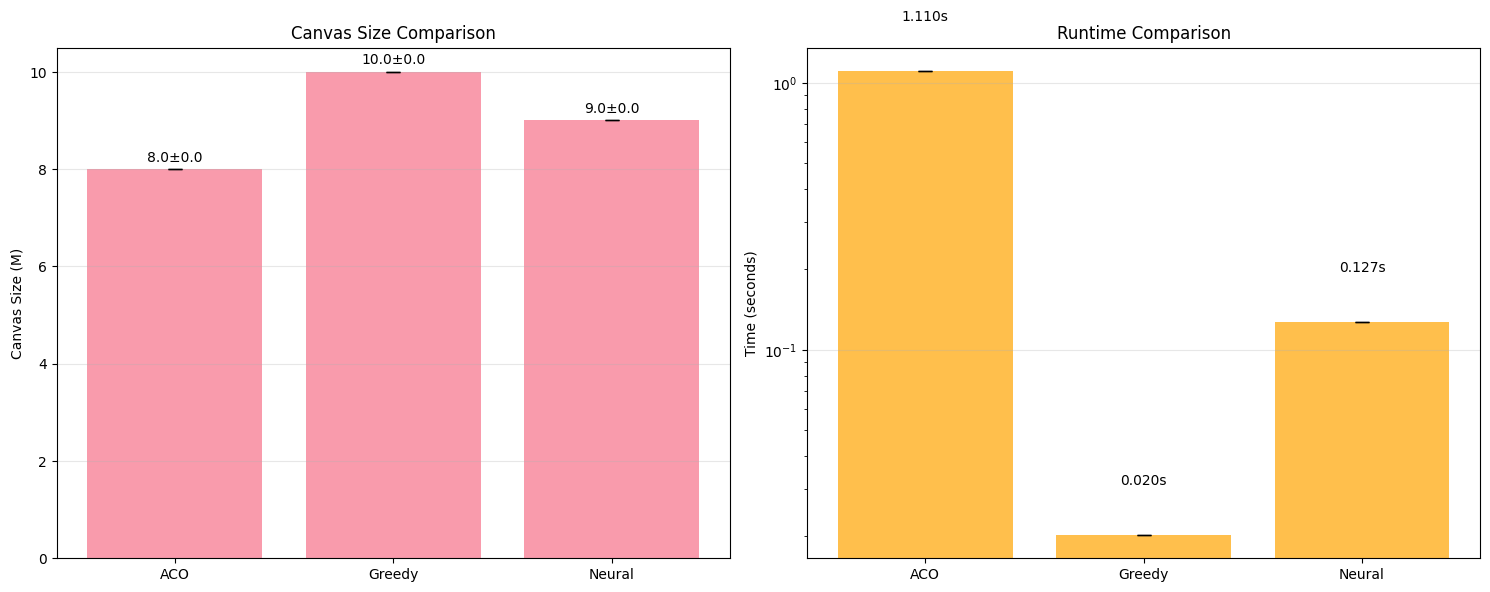


Testing completed for 1 instances!


In [46]:
print(f"\n{'='*80}")
print("AGGREGATE RESULTS ANALYSIS")
print(f"{'='*80}")

# Collect method names
method_names = set()
for result in all_results:
    method_names.update(result.keys())

# Analysis data for plotting
method_stats = {}

for method in sorted(method_names):
    valid_results = []
    errors = 0
    
    for result in all_results:
        if method in result:
            if "error" not in result[method]:
                valid_results.append(result[method])
            else:
                errors += 1
    
    if valid_results:
        best_ms = [r["best_m"] for r in valid_results]
        times = [r["time"] for r in valid_results]
        
        method_stats[method] = {
            "name": valid_results[0]['method'],
            "successful_runs": len(valid_results),
            "errors": errors,
            "best_ms": best_ms,
            "times": times,
            "mean_m": np.mean(best_ms),
            "std_m": np.std(best_ms),
            "min_m": min(best_ms),
            "max_m": max(best_ms),
            "mean_time": np.mean(times),
            "std_time": np.std(times)
        }
        
        print(f"\n{valid_results[0]['method']} Solver:")
        print(f"  Successful runs: {len(valid_results)}/{CONFIG['test_size']}")
        if errors > 0:
            print(f"  Errors: {errors}")
        print(f"  Best M - Mean: {np.mean(best_ms):.2f} ± {np.std(best_ms):.2f}")
        print(f"         Range: [{min(best_ms)}, {max(best_ms)}]")
        print(f"  Time   - Mean: {np.mean(times):.3f}s ± {np.std(times):.3f}s")
    else:
        print(f"\n{method} Solver: No successful runs")

# Create performance comparison plots
if len(method_stats) > 1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Canvas size comparison
    methods = list(method_stats.keys())
    means = [method_stats[m]['mean_m'] for m in methods]
    stds = [method_stats[m]['std_m'] for m in methods]
    names = [method_stats[m]['name'] for m in methods]
    
    bars1 = ax1.bar(names, means, yerr=stds, capsize=5, alpha=0.7)
    ax1.set_ylabel('Canvas Size (M)')
    ax1.set_title('Canvas Size Comparison')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, mean, std in zip(bars1, means, stds):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + std + 0.1,
                f'{mean:.1f}±{std:.1f}', ha='center', va='bottom')
    
    # Plot 2: Time comparison
    times_mean = [method_stats[m]['mean_time'] for m in methods]
    times_std = [method_stats[m]['std_time'] for m in methods]
    
    bars2 = ax2.bar(names, times_mean, yerr=times_std, capsize=5, alpha=0.7, color='orange')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_title('Runtime Comparison')
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_yscale('log')  # Log scale for time comparison
    
    # Add value labels on bars
    for bar, mean, std in zip(bars2, times_mean, times_std):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height * 1.5,
                f'{mean:.3f}s', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Box plots for detailed distribution analysis
    if CONFIG['test_size'] > 2:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Box plot for canvas sizes
        canvas_data = [method_stats[m]['best_ms'] for m in methods]
        ax1.boxplot(canvas_data, labels=names)
        ax1.set_ylabel('Canvas Size (M)')
        ax1.set_title('Canvas Size Distribution')
        ax1.grid(axis='y', alpha=0.3)
        
        # Box plot for times
        time_data = [method_stats[m]['times'] for m in methods]
        ax2.boxplot(time_data, labels=names)
        ax2.set_ylabel('Time (seconds)')
        ax2.set_title('Runtime Distribution')
        ax2.set_yscale('log')
        ax2.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()

print(f"\nTesting completed for {CONFIG['test_size']} instances!")

## Export Results (Optional)

In [47]:
# Save results to CSV files (optional)
save_to_csv = False  # Set to True if you want to save results

if save_to_csv:
    results_dir = Path("results")
    results_dir.mkdir(exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Prepare CSV data
    csv_data = []
    
    for instance_idx, instance_results in enumerate(all_results):
        for method_name, result in instance_results.items():
            row = {
                'timestamp': datetime.now().isoformat(),
                'instance_id': instance_idx,
                'method': result.get('method', method_name),
                'T': CONFIG['T'],
                'n': CONFIG['n'],
                'alphabet': CONFIG['alphabet'],
                'seed': CONFIG['seed'] + instance_idx,
                'best_m': result.get('best_m', None),
                'time_seconds': result.get('time', None),
                'status': result.get('status', 'error' if 'error' in result else 'unknown'),
                'error_message': result.get('error', ''),
                'checkpoint': CONFIG.get('checkpoint', ''),
                'temperature': CONFIG.get('temperature', ''),
                'greedy_inference': CONFIG.get('greedy_inference', '')
            }
            csv_data.append(row)
    
    # Save to CSV
    csv_path = results_dir / f"notebook_test_results_{timestamp}.csv"
    if csv_data:
        fieldnames = csv_data[0].keys()
        with open(csv_path, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(csv_data)
        print(f"Results saved to {csv_path}")
    
    # Save summary
    summary_data = []
    for method_name, stats in method_stats.items():
        summary_row = {
            'timestamp': datetime.now().isoformat(),
            'method': stats['name'],
            'T': CONFIG['T'],
            'n': CONFIG['n'],
            'alphabet': CONFIG['alphabet'],
            'test_instances': CONFIG['test_size'],
            'successful_runs': stats['successful_runs'],
            'errors': stats['errors'],
            'best_m_mean': stats['mean_m'],
            'best_m_std': stats['std_m'],
            'best_m_min': stats['min_m'],
            'best_m_max': stats['max_m'],
            'time_mean': stats['mean_time'],
            'time_std': stats['std_time']
        }
        summary_data.append(summary_row)
    
    summary_path = results_dir / f"notebook_test_summary_{timestamp}.csv"
    if summary_data:
        fieldnames = summary_data[0].keys()
        with open(summary_path, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(summary_data)
        print(f"Summary saved to {summary_path}")
else:
    print("CSV export disabled. Set save_to_csv=True to enable.")

print("\nNotebook execution completed!")

CSV export disabled. Set save_to_csv=True to enable.

Notebook execution completed!


## Summary

This notebook provides:

1. **Comprehensive Testing**: Tests multiple solver approaches (Neural, Greedy, ACO, Exact)
2. **Solution Validation**: Checks for conflicts and validates tile placements
3. **Rich Visualization**: 
   - Input tile visualization
   - Solution grid showing values and tile boundaries
   - Performance comparison charts
4. **Statistical Analysis**: Mean, standard deviation, and distribution analysis
5. **Export Capabilities**: Optional CSV export for further analysis

Each solution is validated to ensure:
- No overlapping conflicts (matching values in overlap regions)
- Correct tile placement
- Proper canvas size calculation

The visualizations help understand:
- How tiles are arranged in the solution
- Which method produces more compact solutions
- Performance trade-offs between solution quality and runtime